In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import simpleaudio as sa


In [2]:
tf.config.list_physical_devices('GPU')
import os
from os.path import join as pjoin
import simpleaudio as sa
from scipy.io import wavfile


original_data_dir = pjoin(os.getcwd(),"../AudioFiles","wavs")
compressed_data_dir = pjoin(os.getcwd(),"../AudioFiles","medio")
original_fname = pjoin(original_data_dir, '55_tdcast.wav')
compressed_fname = pjoin(compressed_data_dir, '55_tdcast.wav')

samplerate_original, original_data = wavfile.read(original_fname)
print(f"number of channels = {original_data.shape[1]}")

length = original_data.shape[0] / samplerate_original
print(f"length = {length}s")

samplerate_compressed, compressed_data = wavfile.read(compressed_fname)
fs = samplerate_original

number of channels = 2
length = 1379.4220408163264s


<ipython-input-2-cadf79b310ad>:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_compressed, compressed_data = wavfile.read(compressed_fname)


In [3]:
compressed_data = np.array(compressed_data[:,0].reshape(-1,1))
original_data = np.array(original_data[:,0].reshape(-1,1))

In [4]:

play_obj = sa.play_buffer(compressed_data, 1, 2, samplerate_original)
#play_obj.wait_done()

In [6]:
play_obj.stop()

In [4]:
seq = original_data[:samplerate_original*5]
volume = .3
normalization = 32767 / np.max(np.abs(seq))
audio = (seq[:,0].reshape(-1)*normalization*volume).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)

In [5]:
len(compressed_data) - len(original_data)

0

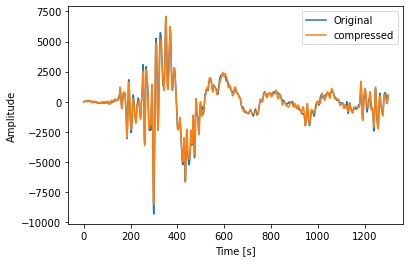

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(original_data[10700:12000, 0], label="Original")
plt.plot(compressed_data[10700:12000, 0], label="compressed")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [8]:
samplesize = 10000 #.25 segundos
clean_audio = original_data#[:5000000]
dirty_audio = compressed_data#[:5000000]

In [9]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)


In [10]:
y = getSamplesFromFile(clean_audio, samplesize)
x = getSamplesFromFile(dirty_audio, samplesize)
val_start = int(len(x)*.9)
X_train,X_valid = x[:val_start],x[val_start:]
Y_train,Y_valid = y[:val_start],y[val_start:]

In [11]:
X_train.shape

(5474, 10000, 1)

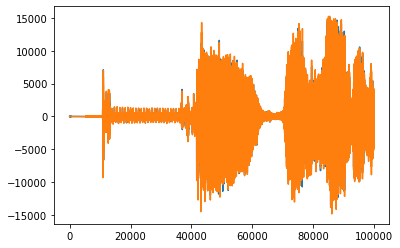

In [12]:
plt.plot(X_train[0:10].reshape(-1))
plt.plot(Y_train[0:10].reshape(-1))
plt.show()

In [ ]:
input_ = keras.layers.Input(shape=X_train.shape[1:])

hidden = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='elu')(input_)
hidden = keras.layers.MaxPooling1D(pool_size=2, padding='same')(hidden)

hidden = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='elu')(hidden)
hidden = keras.layers.MaxPooling1D(pool_size=2, padding='same')(hidden)


hidden = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='elu')(hidden)
hidden = keras.layers.UpSampling1D(size=2)(hidden)

hidden = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='elu')(hidden)
hidden = keras.layers.UpSampling1D(size=2)(hidden)


output = keras.layers.Conv1D(filters=1, kernel_size=3, padding='same')(hidden)

model = keras.models.Model(inputs=[input_], outputs=[output])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10000, 64)         256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5000, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5000, 128)         24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2500, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2500, 128)         49280     
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 5000, 128)         0     

In [16]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.001))
history = model.fit(X_train, Y_train, epochs=20, batch_size=50,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
 24/110 [=====>........................] - ETA: 13s - loss: nan

KeyboardInterrupt: 

In [ ]:
#4928491.5000
#1496164.2500
#2036409.7500 
#Colocar result de 1 densa no relatorio
#Treinar com seq inteira 

In [29]:
model.save_weights('./checkpoints/pure_conv')

In [13]:

model.load_weights('./checkpoints/pure_conv')


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001EFB1B231F0> and <tensorflow.python.keras.layers.convolutional.UpSampling1D object at 0x000001EFB1B359A0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x000001EFB1B3EC40> and <tensorflow.python.keras.layers.convolutional.UpSampling1D object at 0x000001EFB1B47D90>).


ValueError: Shapes (3, 128, 128) and (128, 128) are incompatible

In [2]:
predicted = model.predict(X_valid)

NameError: name 'model' is not defined

In [36]:
predicted.shape

(609, 10000, 1)

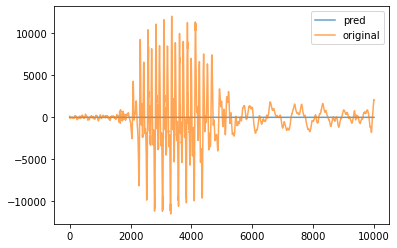

In [19]:
plt.plot(predicted[0].reshape(-1), label="pred", alpha=.7)
plt.plot(Y_valid[0].reshape(-1), label="original", alpha=.7)
plt.legend()
plt.show()

In [1]:
plt.plot(predicted[0].reshape(-1), label="pred", alpha=.7)
#plt.plot(X_valid[0].reshape(-1), label="original", alpha=.7)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [78]:
predicted = model.predict(X_train)

In [79]:
X_train.shape

(450000, 10, 1)

In [22]:
def play_seq(seq, volume):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)
    return play_obj

In [111]:
x = play_seq(X_valid, 1) #Comprimido

In [112]:
x.stop()

In [24]:
x = play_seq(predicted, 1) #Predito

In [26]:
x.stop()

In [98]:
x= play_seq(Y_valid, .8) #Oliginal

In [99]:
x.stop()

In [170]:
def save_seq(name,seq, volume, samplerate):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    wavfile.write(name,samplerate*2,audio)

In [186]:
save_seq("predicted.wav", predicted, .5, samplerate)
save_seq("shouldbe.wav", Y_train, 1, samplerate)
save_seq("itwas.wav", X_train, 1, samplerate)

In [163]:
predicted.shape

(90000, 10, 1)